In [57]:
# Import libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import OrderedDict
from sklearn.cluster import KMeans
import collections
import matplotlib.pyplot as plt
sns.set(style="darkgrid")


In [60]:
# load datasest
df_pcr = pd.read_excel("./data/IgM Rapid Test-IgM ELISA-3rd dataset (All are SARS-CoV-2 qPT-PCR positive).xlsx", header=0, comment="#")
# replace unknown with average age
known_age = df_pcr[df_pcr["Age"] != "Unknow."]
#known_age.boxplot("Age")
avg_age = round(known_age["Age"].mean())
df_pcr["Age"] = df_pcr["Age"].replace("Unknow.", avg_age)
# further cleanup
indexNames = df_pcr[df_pcr['IgM/Rt '] == 'no'].index
 
# Delete these row indexes from dataFrame
df_pcr.drop(indexNames , inplace=True)

# set age to numeric
df_pcr["Age"] = df_pcr["Age"].astype(int)

# bin ages
df_pcr["Age bin"] = pd.cut(x=df_pcr['Age'], 
                       bins=[9, 20, 29, 39, 49, 59, 69, 79, 89], 
                       labels=['10s', '20s', '30s', '40s', '50s','60s', '70s', '80s'])
df_pcr= df_pcr.convert_dtypes()

# create target column
def encode_symptoms(row):
    wanted = row["Sym. grade"]
    if str(wanted) == "0":
        return 0
    return 1

df_pcr["target"] = df_pcr.apply(encode_symptoms, axis=1)


# create target column
def encode_symptoms(row):
    wanted = row["Sym. grade"]
    if str(wanted) == "0":
        return "no"
    return "yes"
df_pcr["symptoms_presence"] = df_pcr.apply(encode_symptoms, axis=1)

# create fold column
def encode_fold_change_igG(row):
    wanted = row["IgG/ODs"]
    fc = (float(wanted)/0.542) - 1
    return fc

df_pcr["fold_change_IgG"] = df_pcr.apply(encode_fold_change_igG, axis=1)

def encode_fold_change_igM(row):
    wanted = row["IgM/ODs"]
    fc = (float(wanted)/0.498) - 1
    return fc
df_pcr["fold_change_IgM"] = df_pcr.apply(encode_fold_change_igM, axis=1)



len(df_pcr)

45

In [61]:
df_pcr["IgM fold bin"] = pd.cut(x=df_pcr['fold_change_IgM'], 
                       bins=[-0.9, 0, 0.5, 1, 1.5, 2, 2.5, 3], 
                       labels=['bfc', '0.5fc', '1fc', '1.5fc', '2fc', '2.5fc','3fc'])

In [62]:
df_pcr["IgG fold bin"] = pd.cut(x=df_pcr['fold_change_IgG'], 
                       bins=[-0.9, 0, 0.5, 1, 1.5, 2, 2.5, 3], 
                       labels=['bfc', '0.5fc', '1fc', '1.5fc', '2fc', '2.5fc','3fc'])

In [108]:
df_pcr_symptomatic = df_pcr[df_pcr["target"] == 1]
df_wanted_cols = df_pcr_symptomatic[["fold_change_IgG","fold_change_IgM"]]
df_wanted_cols.columns = ["IgG", "IgM"]

In [71]:
# load datasest
df_antibody = pd.read_excel("./data/IgM-IgG_ELISA_Rapid_Test_Symptoms.xlsx", header=0, comment="#")

# further cleanup
indexNames = df_antibody[df_antibody['Age'] == 'NS'].index
 
# Delete these row indexes from dataFrame
df_antibody.drop(indexNames , inplace=True)

# set age to numeric
df_antibody["Age"] = df_antibody["Age"].astype(int)

# bin ages
df_antibody["Age bin"] = pd.cut(x=df_antibody['Age'], 
                       bins=[10, 20, 29, 39, 49, 59, 69, 79, 89], 
                       labels=['10s', '20s', '30s', '40s', '50s','60s', '70s', '80s'])

# remove empty cells
df_antibody = df_antibody.dropna(axis=0)

df_antibody = df_antibody.convert_dtypes()

# create class column
def get_class(row):
    wanted = row["lab-ID"]
    return wanted.split("-")[0]

df_antibody["status"] = df_antibody.apply(get_class, axis=1)

# create target column
def encode_symptoms(row):
    wanted = row["Symptoms"]
    if str(wanted) == "no":
        return 0
    return 1

df_antibody["target"] = df_antibody.apply(encode_symptoms, axis=1)

# create fold column
def encode_fold_change_igG(row):
    wanted = row["IgG/ODs"]
    fc = (float(wanted)/0.542) - 1
    return fc

df_antibody["fold_change_IgG"] = df_antibody.apply(encode_fold_change_igG, axis=1)

def encode_fold_change_igM(row):
    wanted = row["IgM/ODs"]
    fc = (float(wanted)/0.498) - 1
    return fc
df_antibody["fold_change_IgM"] = df_antibody.apply(encode_fold_change_igM, axis=1)

len(df_antibody)

89

In [72]:
df_antibody["IgM fold bin"] = pd.cut(x=df_antibody['fold_change_IgM'], 
                       bins=[-0.9, 0, 0.5, 1, 1.5, 2, 2.5, 3], 
                       labels=['bfc', '0.5fc', '1fc', '1.5fc', '2fc', '2.5fc','3fc'])

In [73]:
df_antibody["IgG fold bin"] = pd.cut(x=df_antibody['fold_change_IgG'], 
                       bins=[-0.9, 0, 0.5, 1, 1.5, 2, 2.5, 3], 
                       labels=['bfc', '0.5fc', '1fc', '1.5fc', '2fc', '2.5fc','3fc'])

In [111]:
df_antibody_symptomatic = df_antibody[df_antibody["target"] == 1]
df_wanted_cols_ab = df_antibody_symptomatic[["fold_change_IgG","fold_change_IgM"]]
df_wanted_cols_ab.columns = ["IgG", "IgM"]


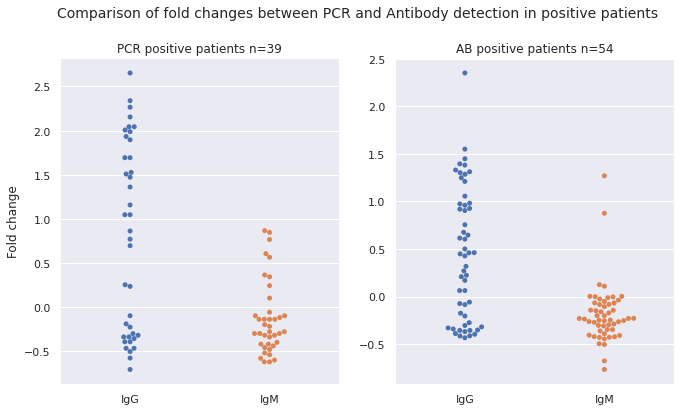

In [131]:
fig, axs = plt.subplots(ncols=2, figsize=(11,6))
ax = sns.swarmplot(data=df_wanted_cols, ax=axs[0])
ax.set(ylabel="Fold change")
ax = sns.swarmplot(data=df_wanted_cols_ab, ax=axs[1])
#ax.set(ylabel="Fold change")
axs[0].set_title('PCR positive patients n=39')
axs[1].set_title('AB positive patients n=54')
plt.suptitle("Comparison of fold changes between PCR and Antibody detection in positive patients", fontsize=14, y=1)
fig.savefig("plots/fold_change_swarm_plot.png")

In [88]:
hss = df_antibody_symptomatic[df_antibody_symptomatic["status"] == "HSS"] 
lss = df_antibody_symptomatic[df_antibody_symptomatic["status"] == "LSS"] 

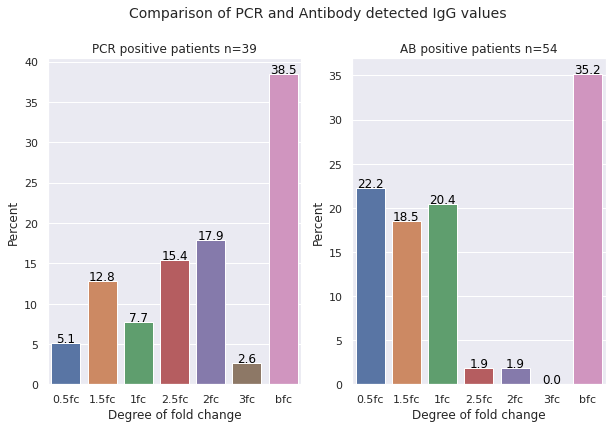

In [132]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))
d = dict(df_pcr_symptomatic["IgG fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[0])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
d = dict(df_antibody_symptomatic["IgG fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[1])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
axs[0].set_title('PCR positive patients n=39')
axs[1].set_title('AB positive patients n=54')
plt.suptitle("Comparison of PCR and Antibody detected IgG values", fontsize=14, y=1)
fig.savefig("plots/proportion_of_fold_change_IgG_plot.png")

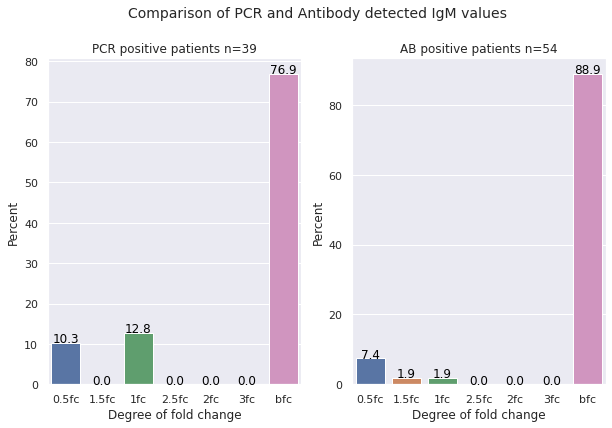

In [133]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))
d = dict(df_pcr_symptomatic["IgM fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[0])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
d = dict(df_antibody_symptomatic["IgM fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[1])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
axs[0].set_title('PCR positive patients n=39')
axs[1].set_title('AB positive patients n=54')
plt.suptitle("Comparison of PCR and Antibody detected IgM values", fontsize=14, y=1)
fig.savefig("plots/proportion_of_fold_change_IgM_plot.png")

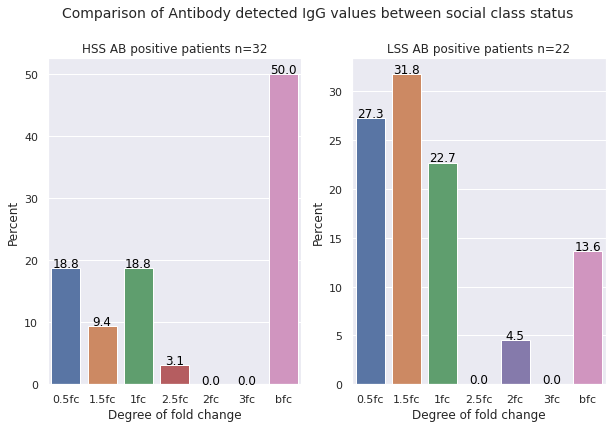

In [134]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))
d = dict(hss["IgG fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[0])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
d = dict(lss["IgG fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[1])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
axs[0].set_title('HSS AB positive patients n=32')
axs[1].set_title('LSS AB positive patients n=22')
plt.suptitle("Comparison of Antibody detected IgG values between social class status", fontsize=14, y=1)
fig.savefig("plots/proportion_of_fold_change_IgG_plot_between_social_status.png")

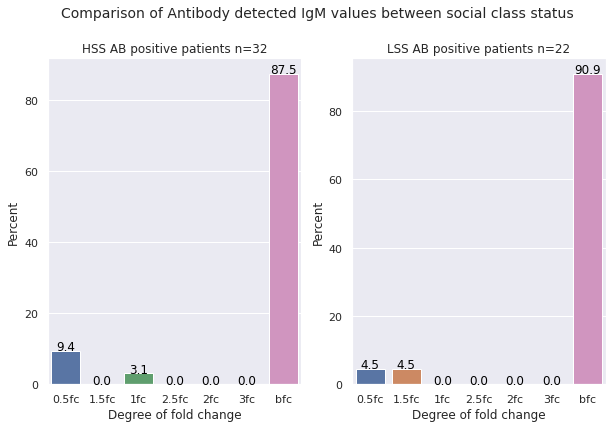

In [135]:
fig, axs = plt.subplots(ncols=2, figsize=(10,6))
d = dict(hss["IgM fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[0])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
d = dict(lss["IgM fold bin"].value_counts(normalize=True).mul(100).round(1))
count_dict = collections.OrderedDict(sorted(d.items()))
ax = sns.barplot(y=list(count_dict.values()), x=list(count_dict.keys()), ax=axs[1])
ax.set(ylabel="Percent")
ax.set(xlabel="Degree of fold change")
   # ax.legend(title='Symptoms presence', bbox_to_anchor=(1.05, 1), loc='upper left')
for index, text in enumerate(ax.get_xticklabels()):
    label = count_dict[text.get_text()]
    ax.text(index,
            label + 0.1,
            str(label),
            horizontalalignment='center',
            size='medium',
            color='black',
            weight='normal')
axs[0].set_title('HSS AB positive patients n=32')
axs[1].set_title('LSS AB positive patients n=22')
plt.suptitle("Comparison of Antibody detected IgM values between social class status", fontsize=14, y=1)
fig.savefig("plots/proportion_of_fold_change_IgM_plot_between_social_status.png")

In [119]:
cont_table_igG_pcr = pd.crosstab(df_pcr_symptomatic["IgG fold bin"], df_pcr_symptomatic["Sym. grade"] )

In [120]:
cont_table_igG_pcr

Sym. grade,1,2,3,4
IgG fold bin,,,,
bfc,5,3,5,2
0.5fc,0,1,1,0
1fc,0,0,1,2
1.5fc,3,0,2,0
2fc,4,2,1,0
2.5fc,1,2,3,0
3fc,1,0,0,0


In [121]:
cont_table_igM_pcr = pd.crosstab(df_pcr_symptomatic["IgM fold bin"], df_pcr_symptomatic["Sym. grade"] )

In [122]:
cont_table_igM_pcr

Sym. grade,1,2,3,4
IgM fold bin,,,,
bfc,10,5,11,4
0.5fc,1,3,0,0
1fc,3,0,2,0


In [123]:
cont_table_igG_ab = pd.crosstab(df_antibody_symptomatic["IgG fold bin"], df_pcr_symptomatic["Sym. grade"] )

In [124]:
cont_table_igG_ab

Sym. grade,1,2,3,4
IgG fold bin,,,,
bfc,2,0,2,0
0.5fc,4,2,0,0
1fc,1,1,1,2
1.5fc,1,0,5,1


In [125]:
cont_table_igM_ab = pd.crosstab(df_antibody_symptomatic["IgM fold bin"], df_pcr_symptomatic["Sym. grade"] )

In [126]:
cont_table_igM_ab

Sym. grade,1,2,3,4
IgM fold bin,,,,
bfc,7,3,7,3
0.5fc,1,0,0,0
1.5fc,0,0,1,0
